### Changepoint detection using CUSUM (NIST Method)

#### Scenario 1: Sudden Drift

##### Reference:
NIST CUSUM example is at: https://www.itl.nist.gov/div898/handbook/pmc/section3/pmc323.htm


In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd

sns.set_style('darkgrid')
np.random.seed(42)
#

The data for CUSUM-based changepoint detection is the AUC scores which are the outcome of the MLP classifier. The classifier was first tained using data samples from one distribution (in-control) which has a classificatoin AUC of 0.86. The model was then tested with the test data drawn from the same distribution. The model was also tested with data samples drawn from another distribution (out-of-control) with classification AUC 0.80. 

To simulate the sudden drift scenario, the trained model is first tested with the random samples drawn from the in-control distribution each day for 100 days (day0-99) followed by random samples drawn from the out-of-control distribution for the next 100 days (day 100-199).

As a first step, load the data followed by train the classifier with the in-control data.

In [3]:
# Load Data - AUC 0.86 and  AUC 0.80
data86 = np.load('d0-AUC.86.npy')
data80 = np.load('d5-AUC.80.npy')
#print(data86.shape)
#print(data80.shape)

In [4]:
import sklearn
#print(samples.shape)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')

#--------------------------------------------------------
# Train Classifier - MLP
#--------------------------------------------------------
samples = data86[:,[0,1]]
labels = data86[:,2]


X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.20, random_state=5)
print("Train",X_train.shape)
print("Test",X_test.shape)
mlp = MLPClassifier(hidden_layer_sizes=(2,4,4,1), activation='relu', solver='adam', max_iter=2000,learning_rate_init=0.001,learning_rate="constant",random_state=4,shuffle=True,batch_size=8)
mlp.fit(X_train,y_train)
predict_train = mlp.predict(X_train)
#predict_test = mlp.predict(X_test)

#Evaluate the Model
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

tn, fp, fn, tp = confusion_matrix(y_train,predict_train).ravel()
specificity = tn / (tn+fp)

AUC = roc_auc_score(y_train,predict_train)
print("Specificity:", specificity)
print("AUC:", AUC)
#print(predict_train.shape)

Train (16800, 2)
Test (4200, 2)
[[5910 1308]
 [ 881 8701]]
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      7218
         1.0       0.87      0.91      0.89      9582

    accuracy                           0.87     16800
   macro avg       0.87      0.86      0.87     16800
weighted avg       0.87      0.87      0.87     16800

Specificity: 0.8187863674147964
AUC: 0.863421570265528


Split the out-of-control data into train/test set and draw samples from the test set for simulating the sudden drift scenario

In [5]:
# Samples from the second distribution -  (day100-199)
new_samples = data80[:,[0,1]]
new_labels = data80[:,2]

X_train, X_test80, y_train, y_test80 = train_test_split(new_samples, new_labels, test_size=0.20, random_state=5)

#X_test80.shape

Run 1000 simulations of day0-100 followed by day 100-199, save the AUCs recorded for changepoint detection using CUSUM algorithm. 

Evaluate:
#FPs, #TPs, average, minimum and maximum delay to detect the change point. Each experiment either has a TP or an FP. Once a TP or FP is detected, break out of the loop.

In [6]:
# Simulate 1000 days - Samples from AUC(0.86) from day 0-99 and AUC(0.80) from day100-199
runs = 0
FalsePos =  np.array([])
totalAlarms =  np.array([])
timetoDetect =  np.array([])
while (runs < 1000):
    test_days = 0
    test_AUC =  np.array([])
    while (test_days < 100):     #day0-99 from AUC(0.86)
        test_samples = np.array([])
        test_labels = np.array([])
    

        number_of_rows = X_test.shape[0]
        random_indices = np.random.choice(number_of_rows, 
                                  size=50, 
                                  replace=False)
    
    
        test_samples = X_test[random_indices,:]
        test_labels  = y_test[random_indices]
        #test_samples.shape
        #print(y_test.shape)
        #test_labels

        predict_test = mlp.predict(test_samples)

        #print(confusion_matrix(test_labels,predict_test))
        #print(classification_report(test_labels,predict_test))
        tn, fp, fn, tp = confusion_matrix(test_labels,predict_test).ravel()
        specificity = tn / (tn+fp)


        AUC = roc_auc_score(test_labels,predict_test)
        #print("Specificity:", specificity)
        #print("AUC:", AUC)

        test_AUC = np.append(test_AUC, AUC)
        #print("day",test_days)
        #AUC
        test_days += 1
    
    while (test_days < 200):    #day100-199 from AUC(0.80)
        test_samples80 = np.array([])
        test_labels80 = np.array([])
    

        number_of_rows80 = X_test80.shape[0]
        random_indices80 = np.random.choice(number_of_rows80, 
                                  size=50, 
                                  replace=False)
    
    
        test_samples80 = X_test80[random_indices80,:]
        test_labels80  = y_test80[random_indices80]
        #test_samples.shape
        #print(y_test.shape)
        #test_labels

        predict_test80 = mlp.predict(test_samples80)

        #print(confusion_matrix(test_labels,predict_test))
        #print(classification_report(test_labels,predict_test))
        tn80, fp80, fn80, tp80 = confusion_matrix(test_labels80,predict_test80).ravel()
        specificity80 = tn80 / (tn80+fp80)


        AUC80 = roc_auc_score(test_labels80,predict_test80)
        #print("Specificity:", specificity)
        #print("AUC:", AUC)

        test_AUC = np.append(test_AUC, AUC80)
        #print("day",test_days)
        #AUC
        test_days += 1
    
    #CUSUM for day0-200: outcomes are delay and #FP, #FP+#TP
    num_rows = np.shape(test_AUC)[0]
    in_control_auc = test_AUC[:100]
    x = np.array(test_AUC)

    mu   = np.mean(in_control_auc)
    std  = np.std(in_control_auc)
    h    = 0.5       # A difference of 0.5 AUC will be considered out of control - Similar to threshold from the detecta package
    k    = 0.03    # Similar to drift in the quantile calculation - 0.05 is the 1 sigma change we wish to detect
    
    x_mean = np.zeros(num_rows,dtype=float)
    #S_hi : for positive changes --------------------------
    S_hi = np.zeros(num_rows,dtype=float)
    S_hi[0] = 0.0 # starts with 0
    #Increase in mean = x-mu-k ----------------------------
    mean_hi = np.zeros(num_rows,dtype=float)

    #Decrease in mean = mu-k-x----------------------------
    mean_lo = np.zeros(num_rows,dtype=float)
    #S_lo : for negative changes --------------------------
    S_lo = np.zeros(num_rows,dtype=float)
    S_lo[0] = 0.0 # starts with 0
     #CUSUM: Cumulative sum of x minus mu ------------------
    cusum = np.zeros(num_rows,dtype=float)
    cusum[0] = 0.0 # initialize with 0
    
    for i in range(0, num_rows):
        x_mean[i]  = x[i] - mu  #x_mean 
        mean_hi[i] = x[i] - mu - k
        S_hi[i]    = max(0, S_hi[i-1] + mean_hi[i])
        mean_lo[i] = mu - k - x[i]
        S_lo[i]    = max(0, S_lo[i-1] + mean_lo[i])
        cusum[i]   = cusum[i-1] + x_mean[i]

    x_mean  = np.round(x_mean,decimals=2)
    S_hi    = np.round(S_hi,decimals=2)
    mean_lo = np.round(mean_lo,decimals=2)
    S_lo    = np.round(S_lo,decimals=2)
    cusum   = np.round(cusum,decimals=2)

    # Construct the tabular CUSUM Chart
    chart = np.array([])
    chart = np.column_stack((x.T, x_mean.T, mean_hi.T, S_hi.T, mean_lo.T, S_lo.T, cusum.T))
    np.round(chart, 2)

    #d = 2 *(np.log((1-0.01) / (0.0027)))
    #h = d * 0.5 # h= d*k where k=0.5
    #h = 4 # as per the NIST doc on CUSUM

    #l1 =  np.append(num_rows, data_tabular, axis = 1)
    #l1 = np.concatenate(num_rows.T, data_tabular.T)
    #chart = np.column_stack((num_rows.T, data_tabular.T))
    #chart

    np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
    #print("CUSUM Chart is:\n", np.round(chart,decimals=2))
    #x_mean

    df = pd.DataFrame(chart) 
    df.columns = ['X','x-mu','Increase in Mean', 'S_hi', 'Decrease-in-mean', 'S_lo', 'CUSUM']

    #print(df.to_string())
    #print(chart)
    
    # False positives and Total alarms
    falsePos = 0
    alarms   = 0
    delay = 0
    for i in range(0, num_rows):
        if (S_lo[i] > h):    # h    = 0.5
            alarms += 1        #TP+FP
            delay = i-100+1 # ts is 100 because the change starts at day100
            #print(S_lo[i])
            if (i<100):
                falsePos += 1  #FP 
            break

    # Delay to detect the first changepoint
    #delay = 0
    #for i in range(0, num_rows):
    #    if (S_lo[i] > h):
    #        delay = i-100+1 # ts is 100 because the change starts at day100
    #        break
    
    FalsePos = np.append(FalsePos, falsePos)
    totalAlarms = np.append(totalAlarms, alarms)
    timetoDetect = np.append(timetoDetect, delay)
    #print(falsePos)
    runs += 1  # continue until 1000 runs


In [10]:
#test_AUC.shape
#num_rows = np.shape(test_AUC)[0]
#num_rows
#in_control_auc = test_AUC[:100]
#in_control_auc.shape
#x = np.array(test_AUC)
#test_AUC.shape
#x.shape
print("total number of FPs",np.sum(FalsePos))
print("TPs",np.sum(totalAlarms))
print("avg delay to detect",np.mean(timetoDetect))
print("min Delay",np.min(timetoDetect))
print("max Delay",np.max(timetoDetect))
#timetoDetect
#FalsePos

total number of FPs 0.0
FP+TP 88351.0
avg delay to detect 12.278
min Delay 2.0
max Delay 32.0


In [11]:
timetoDetect
#FalsePos

array([13.00, 13.00, 14.00, 15.00, 5.00, 7.00, 26.00, 8.00, 17.00, 9.00,
       14.00, 13.00, 9.00, 14.00, 12.00, 7.00, 17.00, 15.00, 8.00, 8.00,
       11.00, 10.00, 18.00, 15.00, 9.00, 18.00, 15.00, 21.00, 9.00, 12.00,
       8.00, 24.00, 5.00, 8.00, 16.00, 12.00, 5.00, 14.00, 8.00, 15.00,
       8.00, 11.00, 14.00, 10.00, 11.00, 10.00, 22.00, 16.00, 8.00, 11.00,
       15.00, 11.00, 6.00, 15.00, 18.00, 10.00, 9.00, 14.00, 18.00, 15.00,
       14.00, 15.00, 12.00, 20.00, 18.00, 19.00, 25.00, 8.00, 20.00, 9.00,
       12.00, 16.00, 6.00, 8.00, 12.00, 12.00, 10.00, 9.00, 9.00, 9.00,
       11.00, 11.00, 17.00, 13.00, 15.00, 12.00, 13.00, 15.00, 9.00, 9.00,
       10.00, 13.00, 16.00, 12.00, 7.00, 9.00, 11.00, 14.00, 8.00, 9.00,
       10.00, 6.00, 7.00, 8.00, 14.00, 11.00, 4.00, 15.00, 8.00, 8.00,
       8.00, 10.00, 6.00, 15.00, 13.00, 15.00, 16.00, 29.00, 14.00, 8.00,
       13.00, 11.00, 18.00, 10.00, 28.00, 10.00, 10.00, 9.00, 8.00, 8.00,
       12.00, 17.00, 13.00, 10.00, 10.00, 1

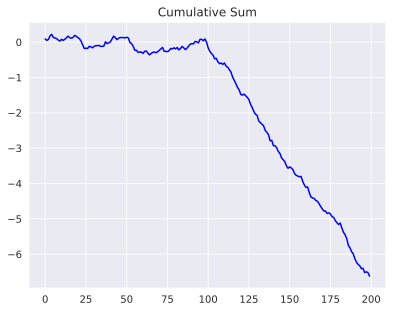

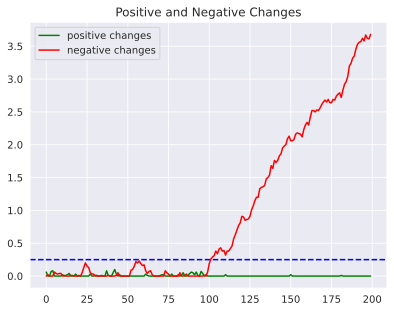

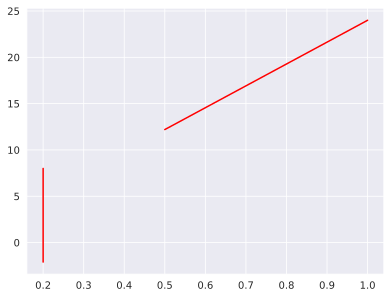

In [12]:
#CUSUM
plt.plot(cusum, '-b')
plt.title('Cumulative Sum')
plt.show()

# specifying horizontal line type
plt.axhline(y = 0.25, color = 'b', linestyle = '--')
plt.plot(S_hi,  '-g', label='positive changes')
plt.plot(S_lo, '-r', label='negative changes')
plt.title('Positive and Negative Changes')
plt.legend()
plt.show()


#Threshold vs. delay
# 1st line
point_1 = [0.5,12.2]
point_2 = [1,24]
point_3 = [0.2,-2.103]

# 2nd line
point_4 = [0.2,8]
point_5 = [0.5,22.8]
point_6 = [0.25,11.7]

x_values = [[point_1[0], point_3[0]],[point_2[0], point_4[0]]]
y_values = [[point_1[1], point_3[1]],[point_2[1], point_4[1]]]

plt.plot(x_values, y_values, 'red')
plt.show()